<a href="https://colab.research.google.com/github/Gowtham181806/AIML-PROJECT/blob/main/Logistic%20Regression%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HR_comma_sep.csv to HR_comma_sep.csv


In [ ]:
!pip install seaborn

In [ ]:
CSV = "HR_comma_sep.csv"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   # <--- this is the missing import


In [ ]:
plt.savefig('salary_vs_retention.png')


<Figure size 640x480 with 0 Axes>

Using CSV path: HR_comma_sep.csv
Rows, cols: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low



Target distribution (left):
left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

Numeric correlations with target 'left':
left                     1.000000
time_spend_company       0.144822
average_montly_hours     0.071287
number_project           0.023787
last_evaluation          0.006567
promotion_last_5years   -0.061788
Work_accident           -0.154622
satisfaction_level      -0.388375
Name: left, dtype: float64


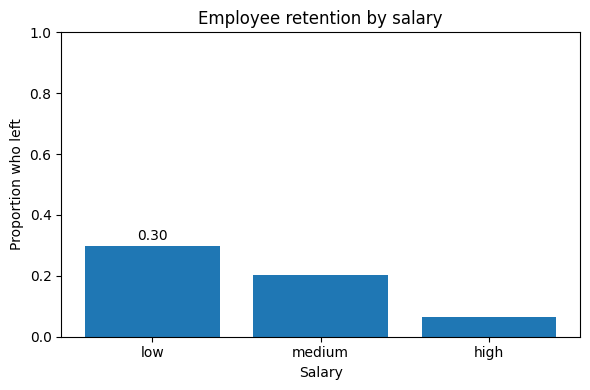

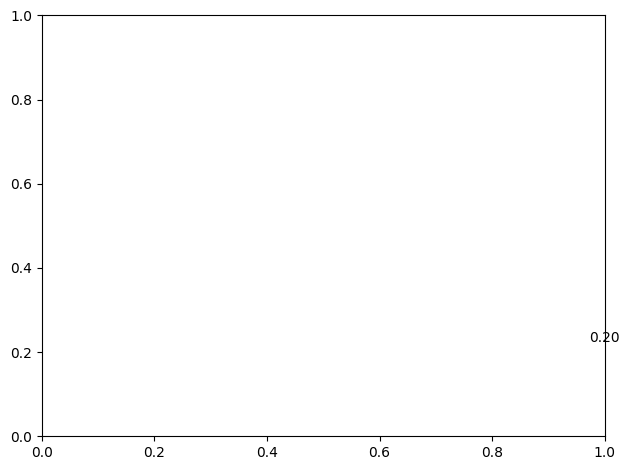

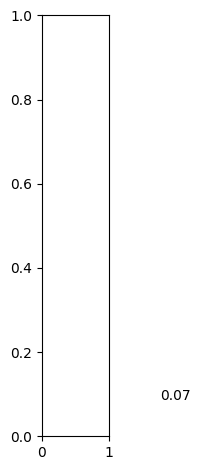

In [9]:
# Colab-ready: EDA + salary/department bar charts + Logistic Regression

# 0) Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files, drive

# 1) Load data: Check for dataset in default paths, otherwise prompt for upload
possible_paths = [
    'HR_comma_sep.csv',  # Check current directory first
    '/content/HR_comma_sep.csv', # Colab's default upload location
    '/content/drive/MyDrive/HR_comma_sep.csv',
    '/content/drive/MyDrive/hr-analytics/HR_comma_sep.csv'
    ]

CSV = None
for p in possible_paths:
    if os.path.exists(p):
            CSV = p
            break
if CSV is None:
    print("No dataset found in default paths. Please upload the CSV file now (choose HR_comma_sep.csv).")
    uploaded = files.upload()
    if len(uploaded) == 0:
            raise FileNotFoundError("No file uploaded. Upload HR_comma_sep.csv and re-run.")
    CSV = list(uploaded.keys())[0]
    print(f"Uploaded file: {CSV}")

print("Using CSV path:", CSV)

# 2) Read data
df = pd.read_csv(CSV)
print("Rows, cols:", df.shape)
display(df.head())
# 3) Quick checks
print("\nTarget distribution (left):")
print(df['left'].value_counts(normalize=True))

# --- Fixed correlation: numeric only ---
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumeric correlations with target 'left':")
corrs = df[numeric_cols].corr()['left'].sort_values(ascending=False)
print(corrs)
# 4) Salary vs retention (bar chart)
salary_group = df.groupby('salary')['left'].mean().reindex(['low','medium','high'])
plt.figure(figsize=(6,4))
bars = plt.bar(salary_group.index, salary_group.values)
plt.ylim(0, 1)
plt.xlabel('Salary')
plt.ylabel('Proportion who left')
plt.title('Employee retention by salary')
for rect, val in zip(bars, salary_group.values):
    plt.text(rect.get_x() + rect.get_width()/2, val + 0.02, f"{val:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
    plt.close()

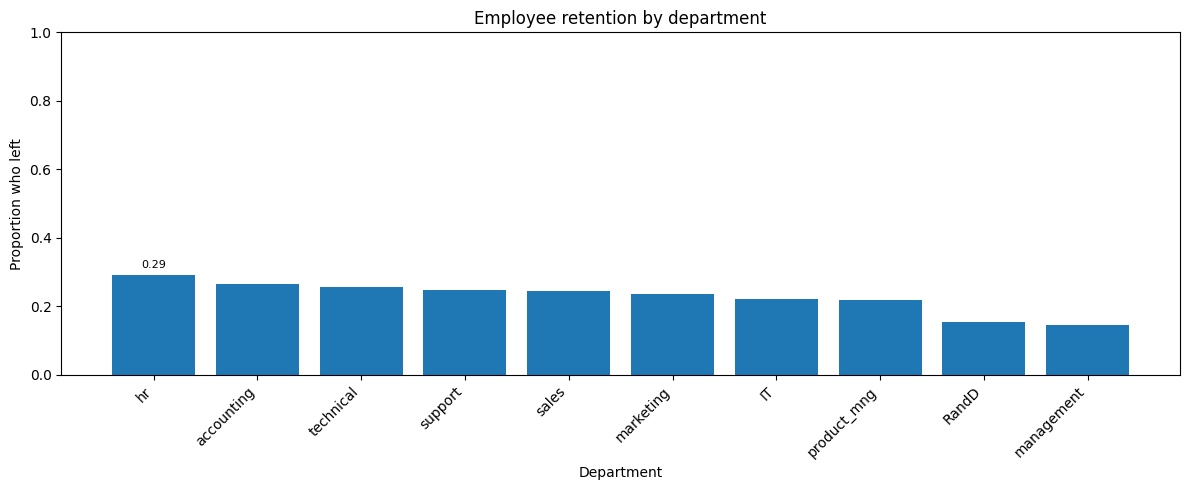

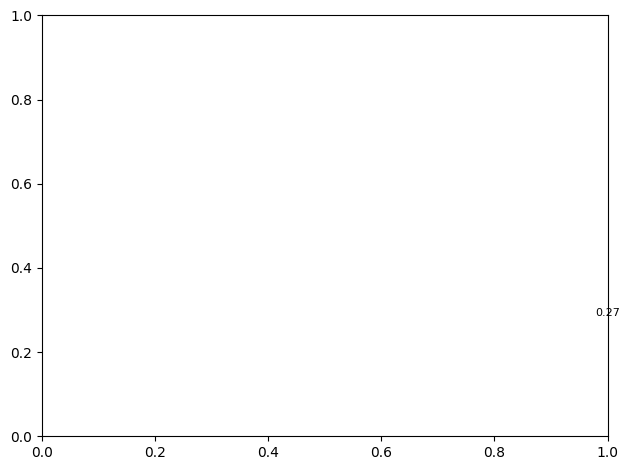

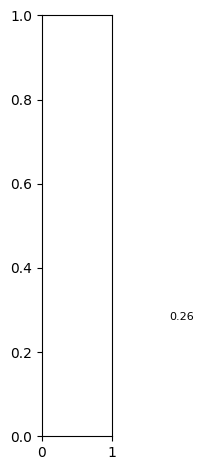

/tmp/ipython-input-2102646216.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


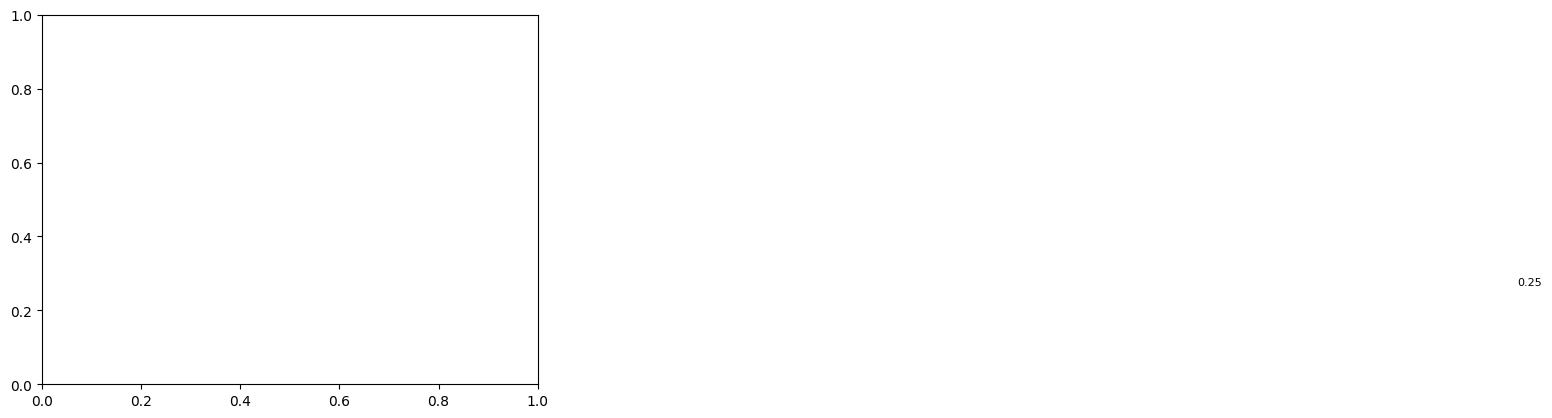

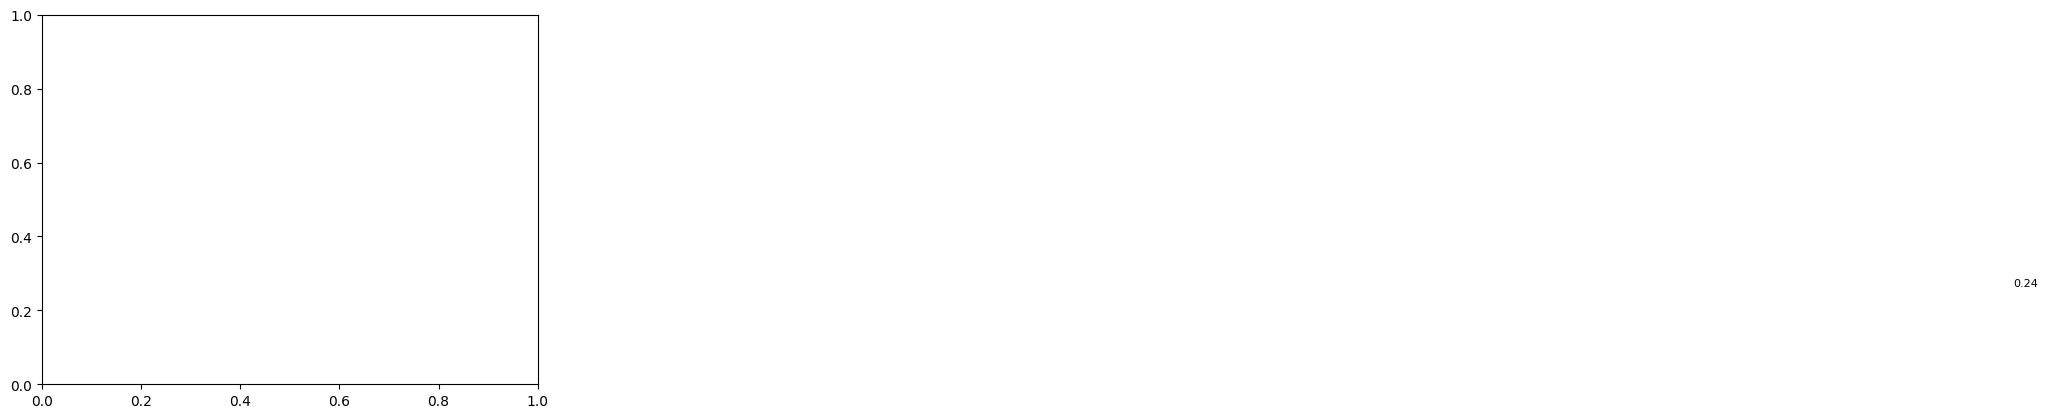

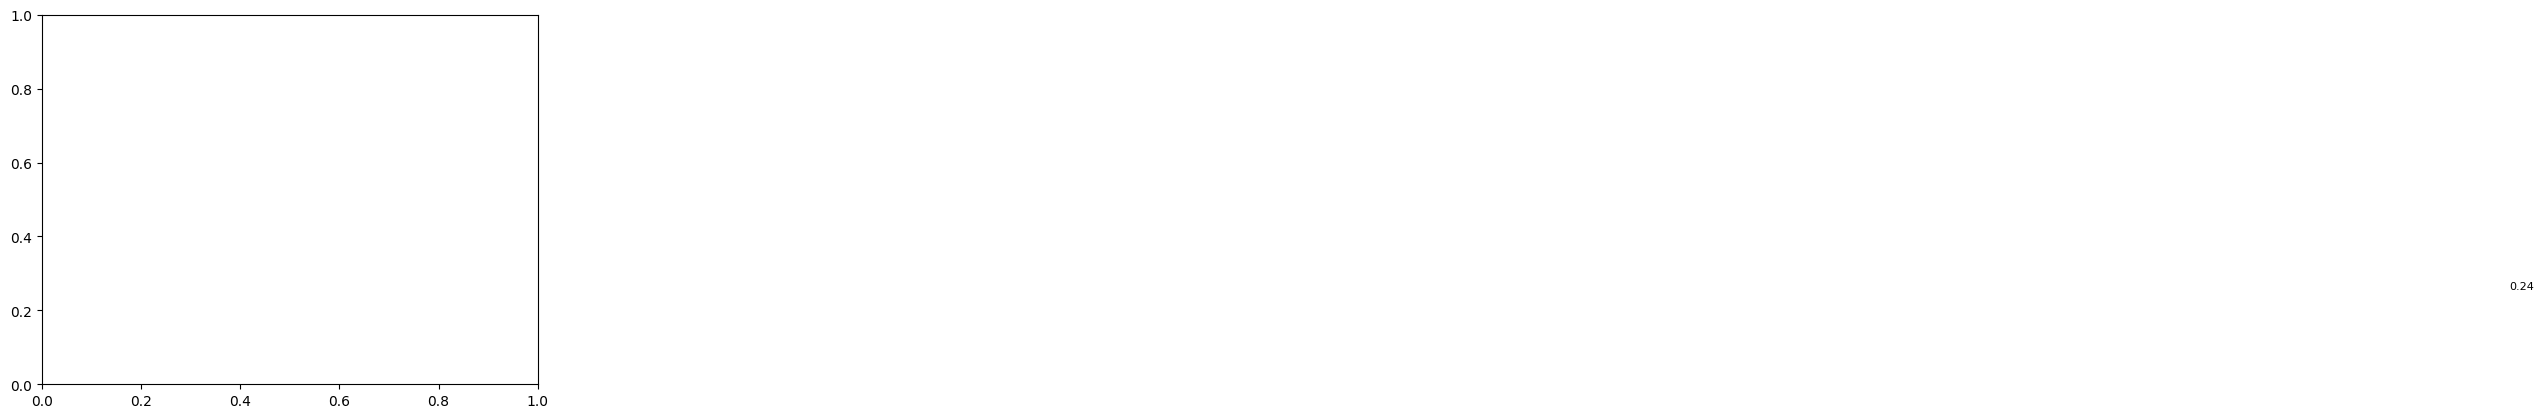

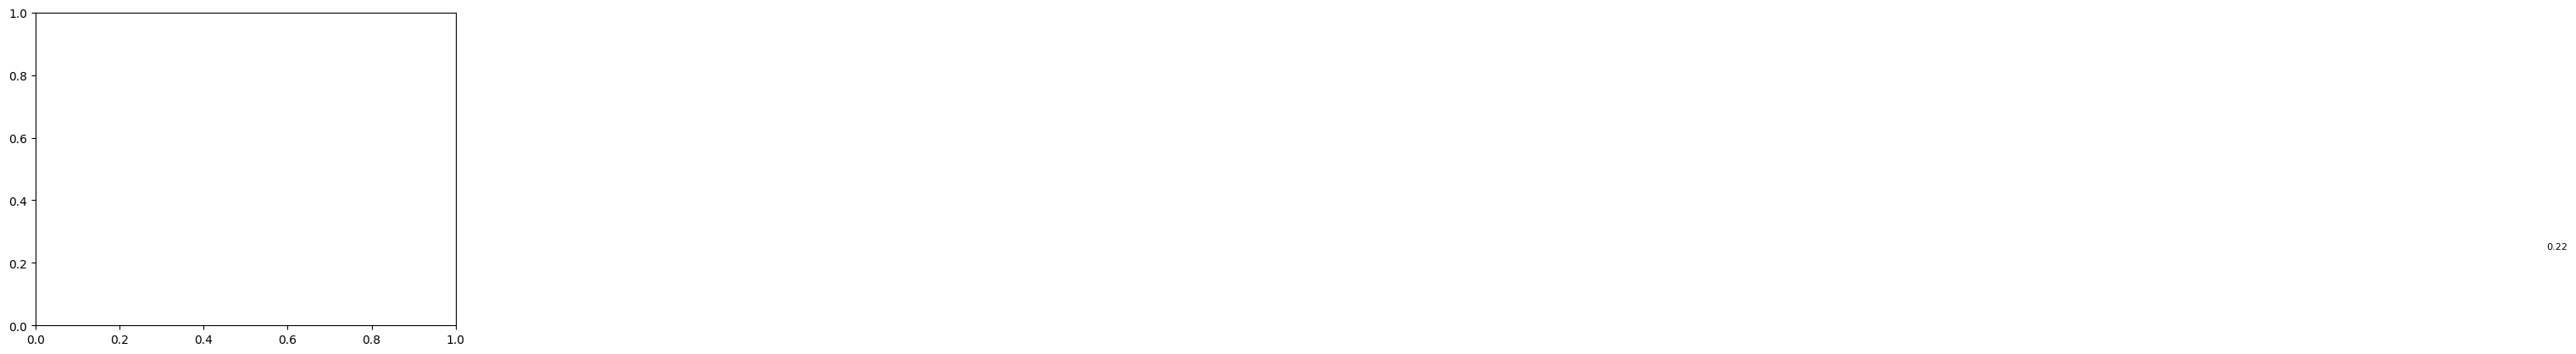

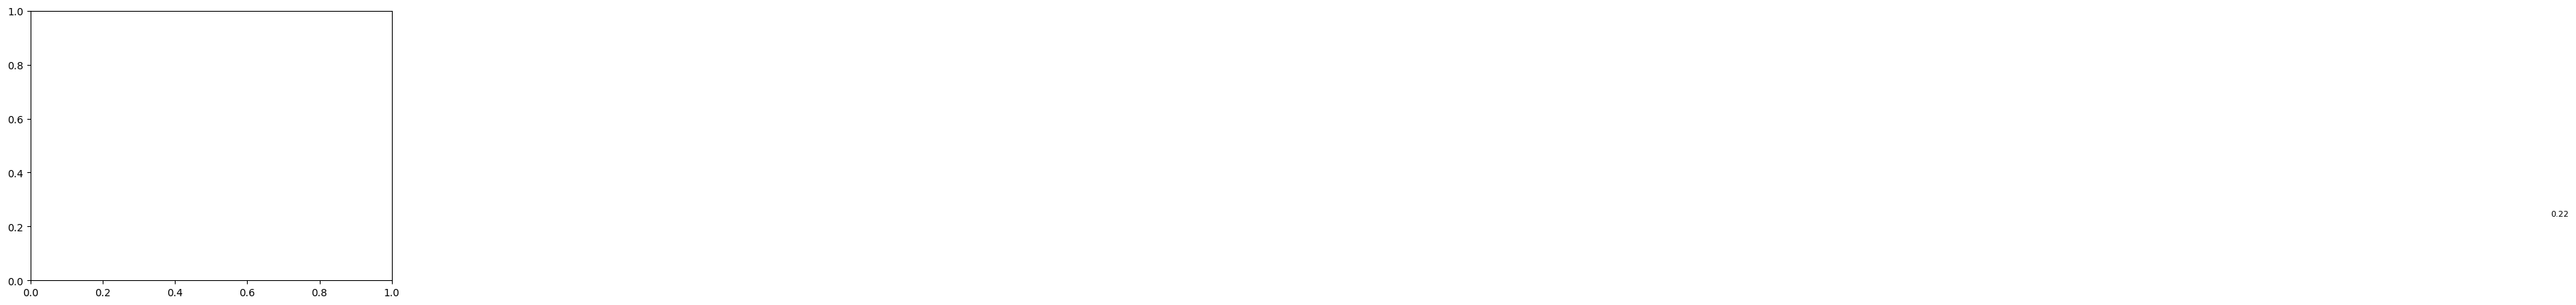

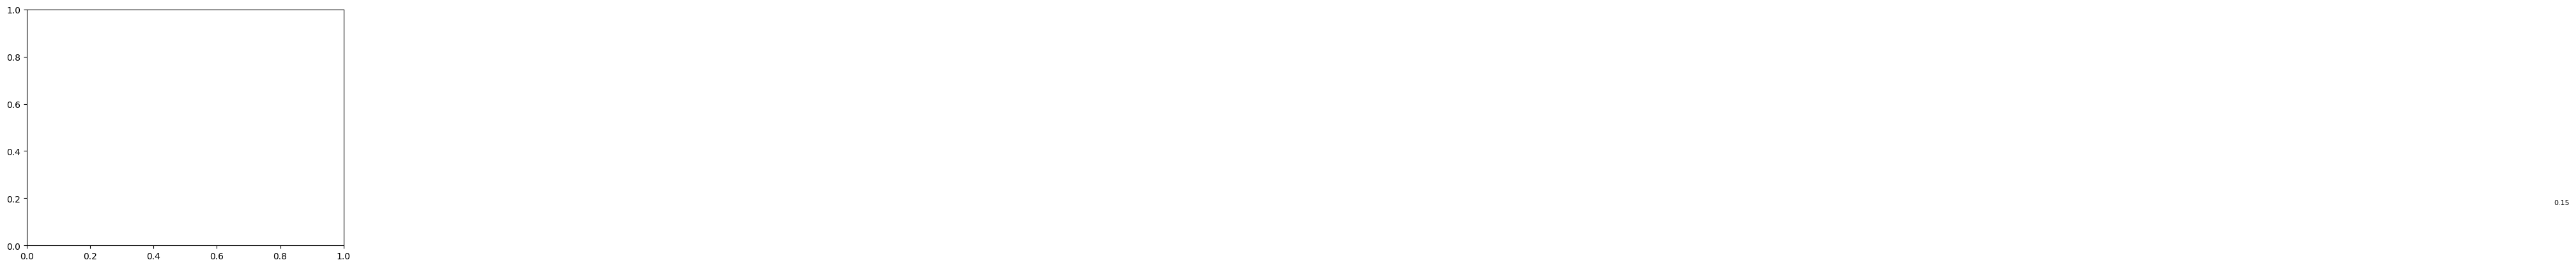

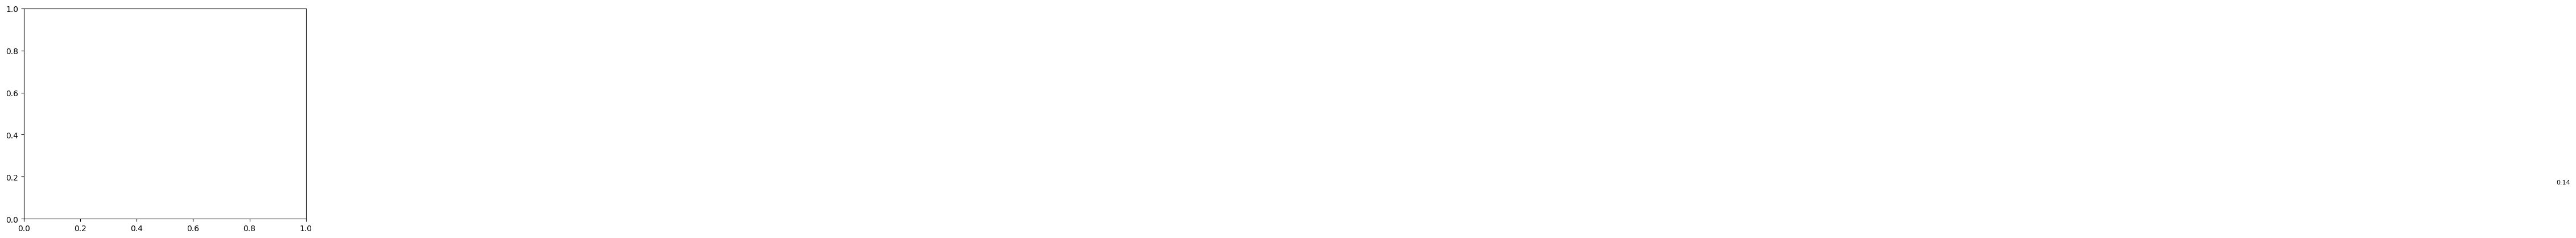

In [10]:
dept_group = df.groupby('Department')['left'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,5))
bars = plt.bar(dept_group.index, dept_group.values)
plt.ylim(0, 1)
plt.xlabel('Department')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Proportion who left')
plt.title('Employee retention by department')
for rect, val in zip(bars, dept_group.values):
    plt.text(rect.get_x() + rect.get_width()/2, val + 0.02, f"{val:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.close()

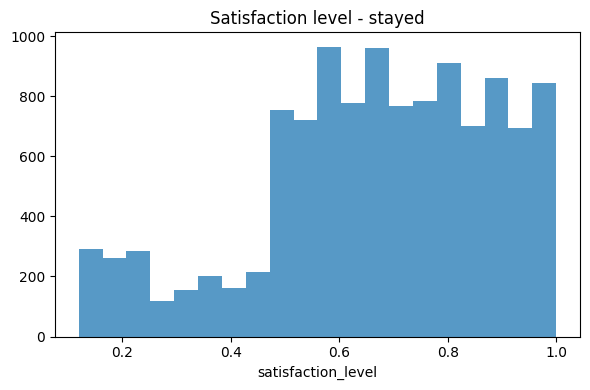

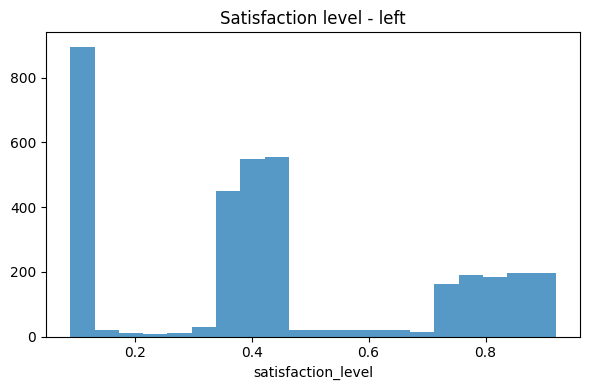

In [11]:
plt.figure(figsize=(6,4))
plt.hist(df[df['left']==0]['satisfaction_level'], bins=20, alpha=0.75)
plt.title('Satisfaction level - stayed')
plt.xlabel('satisfaction_level')
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6,4))
plt.hist(df[df['left']==1]['satisfaction_level'], bins=20, alpha=0.75)
plt.title('Satisfaction level - left')
plt.xlabel('satisfaction_level')
plt.tight_layout()
plt.show()
plt.close()

In [13]:
features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours',
            'time_spend_company', 'salary', 'Department']
X = df[features].copy()
y = df['left'].copy()

# Map salary ordinal
salary_map = {'low':0, 'medium':1, 'high':2}
X['salary_ord'] = X['salary'].map(salary_map)
X = X.drop(columns=['salary'])

numeric_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'salary_ord']
cat_features = ['Department']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

clf = Pipeline(steps=[('pre', preprocessor), ('model', LogisticRegression(max_iter=1000))])

# 9) Train/test split & fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
clf.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['satisfaction_level',
                                                   'last_evaluation',
                                                   'number_project',
                                                   'average_montly_hours',
                                                   'time_spend_company',
                                                   'salary_ord']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Department'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [18]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {rocauc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7717
Precision: 0.5391
Recall: 0.2856
F1-score: 0.3734
ROC AUC: 0.7980

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2857
           1       0.54      0.29      0.37       893

    accuracy                           0.77      3750
   macro avg       0.67      0.60      0.62      3750
weighted avg       0.74      0.77      0.74      3750



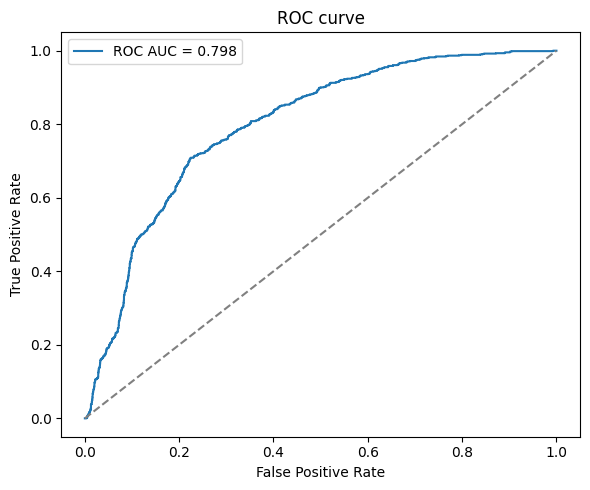

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {rocauc:.3f}')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [23]:
ohe = clf.named_steps['pre'].named_transformers_['cat']
if hasattr(ohe, 'get_feature_names_out'):
    dept_names = ohe.get_feature_names_out(['Department']).tolist()
else:
    dept_names = [f"Department_{c}" for c in ohe.categories_[0]]

feat_names = numeric_features + dept_names
coeffs = clf.named_steps['model'].coef_[0]
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coeffs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)
print("\nTop features by absolute coefficient:")
display(coef_df[['feature','coef']].head(20))


Top features by absolute coefficient:


,feature,coef
0,satisfaction_level,-1.036755
7,Department_RandD,-0.725100
10,Department_management,-0.611849
5,salary_ord,-0.437453
2,number_project,-0.379736
4,time_spend_company,0.351242
9,Department_hr,0.325498
6,Department_IT,-0.225636
3,average_montly_hours,0.223938
12,Department_product_mng,-0.178300
